# What this notebook does

### Title: LLM-scCurator Colab Quickstart (Python)

Scanpy demo (public PBMC3k): run clustering in Python, then curate markers and optionally annotate clusters with an LLM.

Core requirement:
- LLM-scCurator expects log1p-normalized expression in `adata.X`.
  Keep raw counts in `adata.layers["counts"]`.


## Install Python packages + LLM-scCurator

In [ ]:
%pip install -q -U google-generativeai==0.8.5 scanpy==1.11.5 pandas==2.3.3 scipy==1.16.3
#%pip -q install llm-sc-curator


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 86.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.2/174.2 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.1/284.1 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 106.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.


In [ ]:
# install (development)
!git clone https://github.com/kenflab/LLM-scCurator.git
%cd LLM-scCurator
%pip install -e .

Cloning into 'LLM-scCurator'...
remote: Enumerating objects: 1594, done.
remote: Counting objects: 100% (304/304), done.
remote: Compressing objects: 100% (150/150), done.
remote: Total 1594 (delta 264), reused 154 (delta 154), pack-reused 1290 (from 2)
Receiving objects: 100% (1594/1594), 79.43 MiB | 16.23 MiB/s, done.
Resolving deltas: 100% (877/877), done.
Updating files: 100% (149/149), done.
/content/LLM-scCurator
Obtaining file:///content/LLM-scCurator
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 66.5 MB/s eta 0:00:00
  Running setup.py develop for llm-sc-curator


## Imports + reproducibility

In [ ]:
import scanpy as sc
import pandas as pd
import numpy as np
import random, os

import google.generativeai as genai
import llm_sc_curator
from llm_sc_curator import LLMscCurator
from llm_sc_curator.masking import FeatureDistiller

from llm_sc_curator import (
    export_cluster_annotation_table,
    apply_cluster_map_to_cells,
    harmonize_labels,
)

import warnings
warnings.filterwarnings("ignore")

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print(f"🔒 Random seed set to {RANDOM_SEED} for reproducibility.")

🔒 Random seed set to 42 for reproducibility.


## Data input: Scanpy demo PBMC3k

In [ ]:
# Load demo data
adata = sc.datasets.pbmc3k()

# Minimal QC
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata

  0%|          | 0.00/5.58M [00:00<?, ?B/s]

AnnData object with n_obs × n_vars = 2700 × 13714
    obs: 'n_genes'
    var: 'gene_ids', 'n_cells'

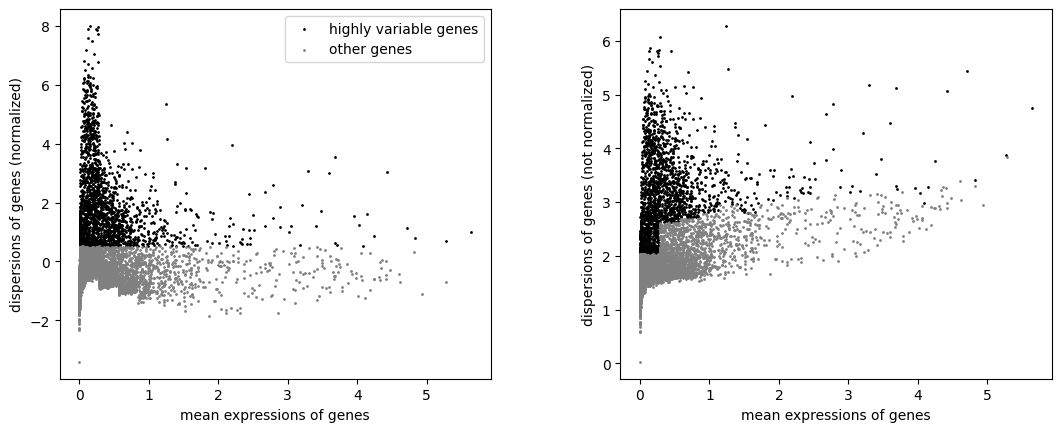

In [ ]:
# Save raw counts, then normalize/log1p into .X (required by LLM-scCurator)
adata.layers["counts"] = adata.X.copy()

# Normalize + log1p (standard)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# HVG selection
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    flavor="seurat",
    subset=False,
)
sc.pl.highly_variable_genes(adata)

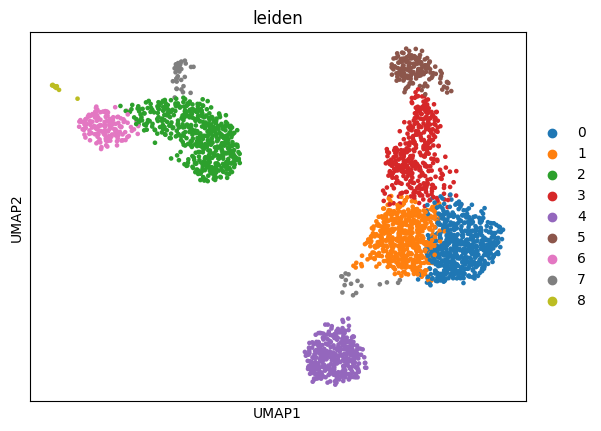

In [ ]:
# PCA/Neighbors/UMAP/Leiden using HVGs
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)
sc.pl.umap(adata, color=["leiden"])


##  Run LLM-scCurator, noise masking and Gini-informed distillation

In [ ]:
ACCURACY_MODE = False  # set False for cheaper/faster

MODEL_NAME = "models/gemini-2.5-pro" if ACCURACY_MODE else "models/gemini-2.0-flash"
print("Using model:", MODEL_NAME)

Using model: models/gemini-2.0-flash


In [ ]:
# Recommended: store your key in Colab Secrets as "GEMINI_API_KEY"
from google.colab import userdata
GEMINI_API_KEY = userdata.get("GEMINI_API_KEY") or "YOUR_KEY_HERE"

In [ ]:
# Curator Initialize
curator = LLMscCurator(api_key=GEMINI_API_KEY, model_name=MODEL_NAME)
curator.set_global_context(adata)

In [ ]:
# Choose a cluster (edit if you want a specific one)
cluster_name = sorted(adata.obs["leiden"].astype(str).unique())[0]
print(f"cluster_name = {cluster_name}")

cluster_name = 0


In [ ]:
# --- Standard DE: Target vs Rest ---
N_GENES = 50
TMP = "__tmp_binary__"

# --- Standard: DE (Target vs Rest) ---
adata.obs[TMP] = "Rest"
adata.obs.loc[adata.obs["leiden"].astype(str) == str(cluster_name), TMP] = "Target"

sc.tl.rank_genes_groups(
    adata,
    groupby=TMP,
    groups=["Target"],
    reference="Rest",
    method="wilcoxon",
    use_raw=False,
)

df_std = sc.get.rank_genes_groups_df(adata, group="Target")
genes_std = df_std["names"].head(N_GENES).tolist()

adata.obs.drop(columns=[TMP], inplace=True, errors="ignore")

# --- Curated: LLM-scCurator ---
genes_cur = curator.curate_features(
    adata,
    group_col="leiden",
    target_group=str(cluster_name),
    n_top=N_GENES,
    use_statistics=True,
)

print("genes_std len =", len(genes_std))
print("genes_cur len =", len(genes_cur))


genes_std len = 50
genes_cur len = 50


In [ ]:
# --- Readable output: lists + rescued/dropped + table ---
def _fmt_list(title, genes, n=10, bullet="•"):
    genes = [str(g) for g in (genes or [])]
    head = genes[:n]
    body = "\n".join([f"{bullet} {g}" for g in head]) if head else f"{bullet} (empty)"
    return f"{title} (top {len(genes)}, showing {min(n, len(genes))})\n{body}"

std = [str(g) for g in genes_std]
cur = [str(g) for g in genes_cur]

std_set = set(std)
cur_set = set(cur)

rescued = [g for g in cur if g not in std_set]
dropped = [g for g in std if g not in cur_set]
overlap = [g for g in cur if g in std_set]

print(f"\nGene list summary: std={len(std)} | curated={len(cur)} | shared={len(overlap)} | rescued={len(rescued)} | dropped={len(dropped)}\n")

print("🟦 " + _fmt_list("Standard genes", std, n=10))
print()
print("🟥 " + _fmt_list("Curated genes", cur, n=10))
print()
print("➕ " + _fmt_list("Rescued (curated-only)", rescued, n=10))
print()
print("➖ " + _fmt_list("Dropped (std-only)", dropped, n=10))

TOP = 15
def _pad(xs, n=TOP):
    xs = [str(x) for x in (xs or [])][:n]
    return xs + [""] * (n - len(xs))

df_view = pd.DataFrame({
    "🏆 rank ": list(range(1, TOP + 1)),
    "🟦 standard ": _pad(genes_std, TOP),
    "🟥 curated ":  _pad(genes_cur, TOP),
})

df_view.insert(0, "cluster", str(cluster_name))
df_view


Gene list summary: std=50 | curated=50 | shared=1 | rescued=49 | dropped=49

🟦 Standard genes (top 50, showing 10)
• RPS27
• RPL32
• RPS12
• RPS6
• RPS25
• RPS3A
• RPL31
• RPL9
• RPS15A
• RPS14

🟥 Curated genes (top 50, showing 10)
• CD3D
• CD3E
• LTB
• SELL
• SRSF5
• MAL
• GIMAP5
• HINT1
• TRAF3IP3
• CD3G

➕ Rescued (curated-only) (top 49, showing 10)
• CD3E
• LTB
• SELL
• SRSF5
• MAL
• GIMAP5
• HINT1
• TRAF3IP3
• CD3G
• LDLRAP1

➖ Dropped (std-only) (top 49, showing 10)
• RPS27
• RPL32
• RPS12
• RPS6
• RPS25
• RPS3A
• RPL31
• RPL9
• RPS15A
• RPS14


,cluster,🏆 rank,🟦 standard,🟥 curated
0,0,1,RPS27,CD3D
1,0,2,RPL32,CD3E
2,0,3,RPS12,LTB
3,0,4,RPS6,SELL
4,0,5,RPS25,SRSF5
5,0,6,RPS3A,MAL
6,0,7,RPL31,GIMAP5
7,0,8,RPL9,HINT1
8,0,9,RPS15A,TRAF3IP3
9,0,10,RPS14,CD3G


## (Optinal) Run LLM-scCurator hierarchical discovery (writes major_type / fine_type)

In [ ]:
# ============================================================
# Optional: automatic hierarchical annotation (coarse-to-fine)
# ============================================================

# This will add columns like adata.obs["major_type"] and adata.obs["fine_type"].
%%time
curator = LLMscCurator(api_key=GEMINI_API_KEY, model_name=MODEL_NAME)

N_GENES = 50

import time
t0 = time.time()
adata_llm = curator.run_hierarchical_discovery(
    adata,
    n_top=N_GENES,
    batch_key=None, # set this if you want batch-aware behavior
)
t1 = time.time()

print(f"run_hierarchical_discovery() total: {t1 - t0:.1f} sec")
display(adata_llm.obs[["major_type","fine_type"]].head())


run_hierarchical_discovery() total: 73.1 sec


,major_type,fine_type
index,,
AAACATACAACCAC-1,CD8+ T cell,CD8+ cytotoxic T cell
AAACATTGAGCTAC-1,B cell,B cell
AAACATTGATCAGC-1,CD8+ T cell,CD8+ T cell (CISH-high)
AAACCGTGCTTCCG-1,Monocyte,Monocyte (HLA-high)
AAACCGTGTATGCG-1,NK cell (cytotoxic),NK cell (cytotoxic)


CPU times: user 16.2 s, sys: 451 ms, total: 16.7 s
Wall time: 1min 13s


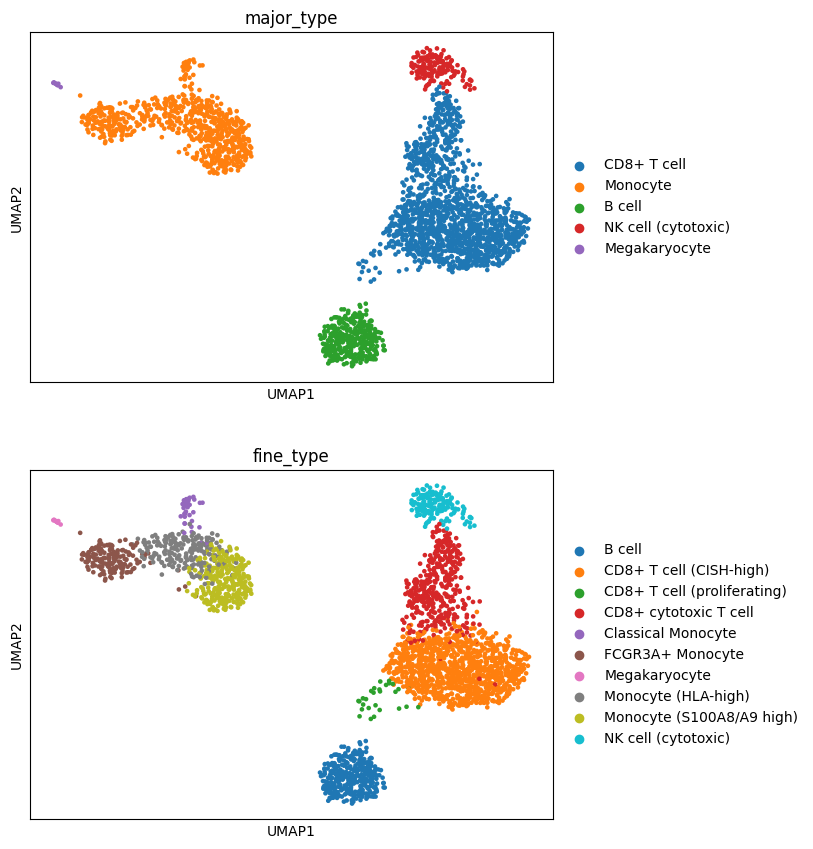

In [ ]:
# Plot only if they exist
cols_to_plot = [c for c in ["major_type", "fine_type"] if c in adata.obs.columns]
if cols_to_plot and "X_umap" in adata.obsm:
    sc.pl.umap(adata, color=cols_to_plot, ncols=1)

## Quick marker dotplots for sanity-checking labels

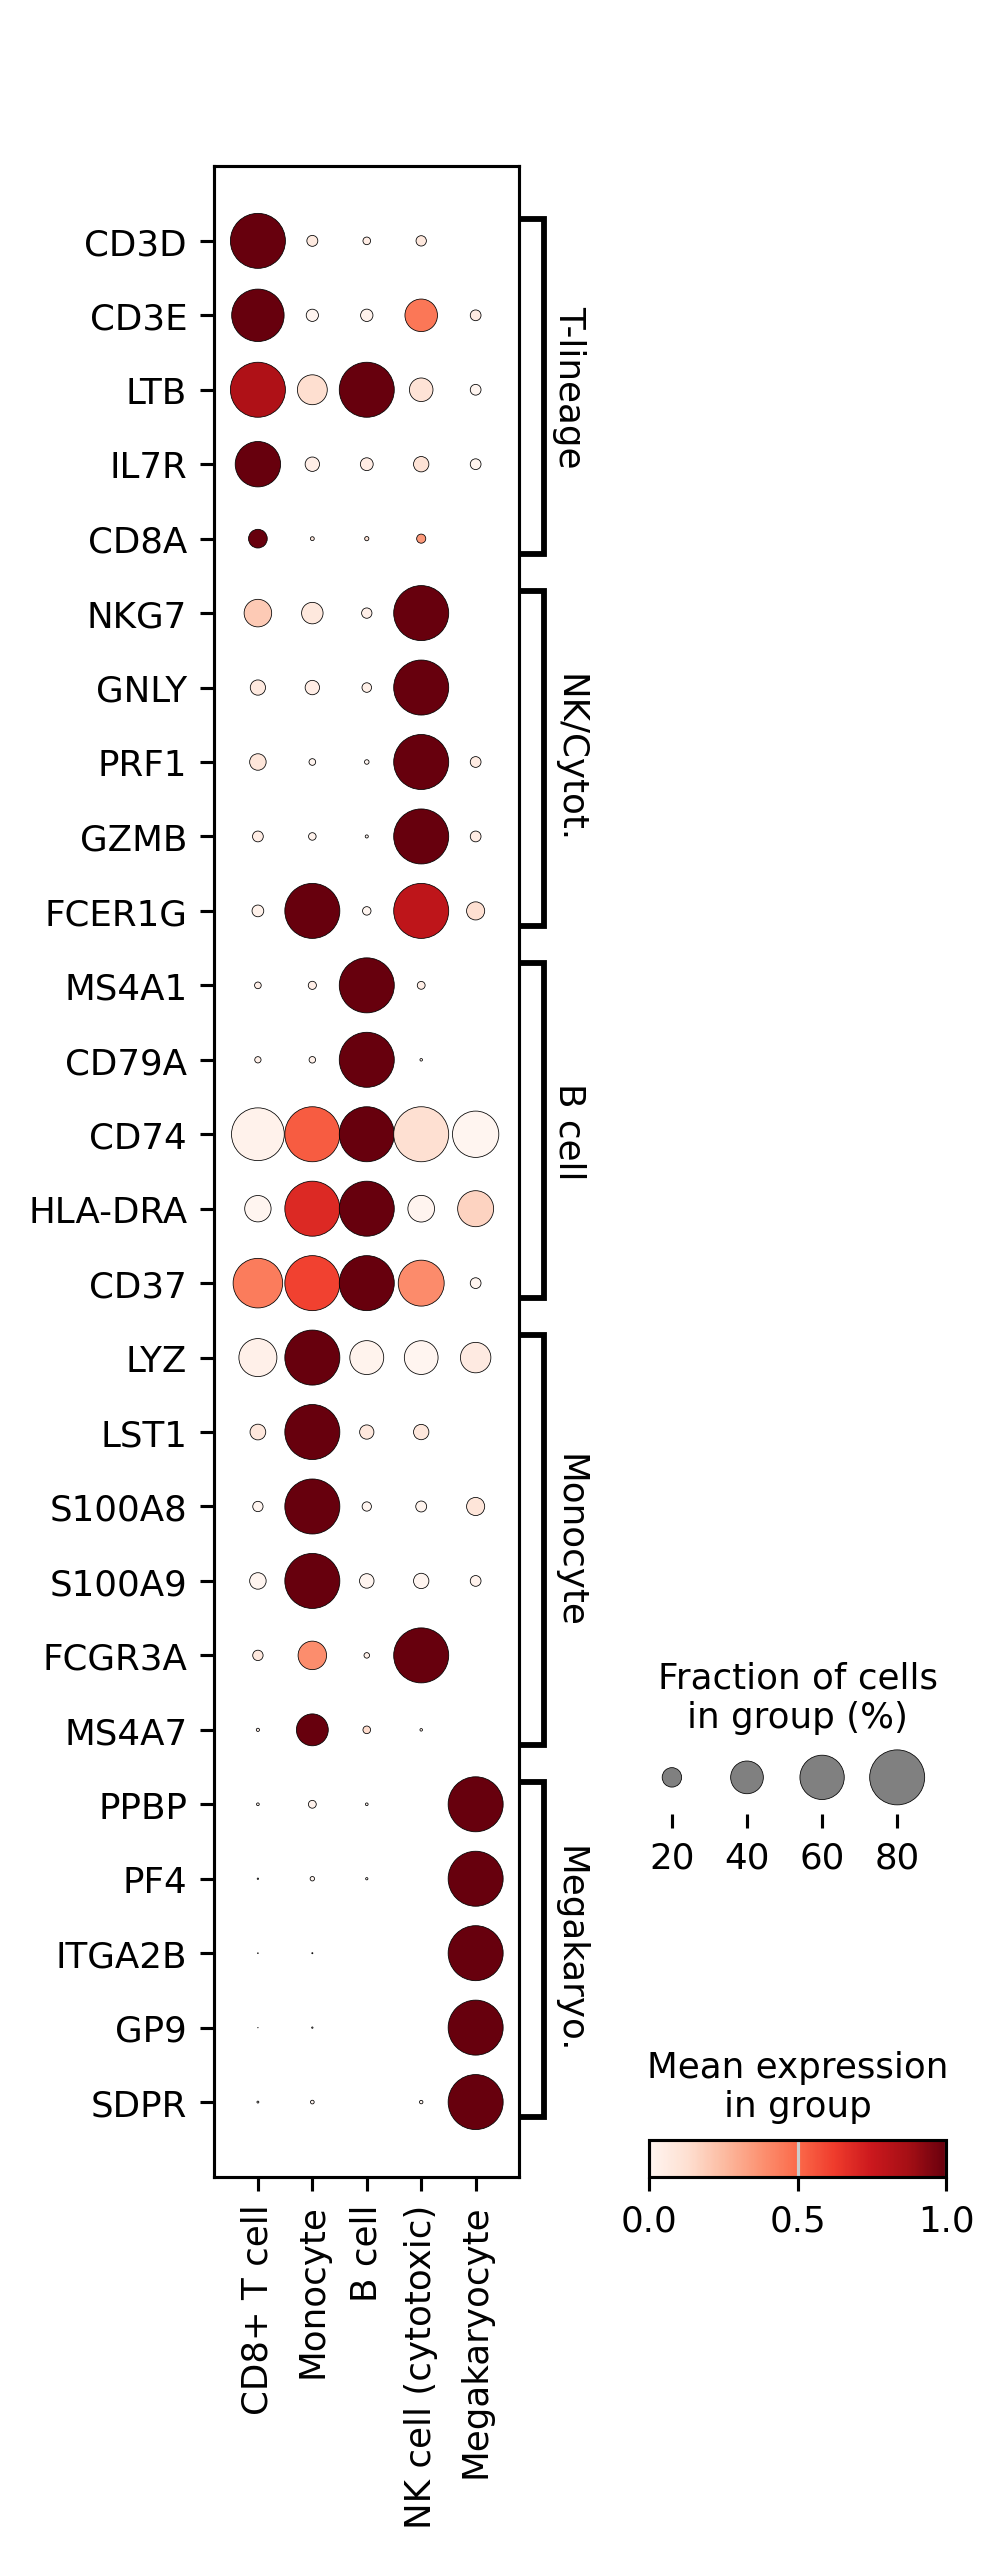

In [ ]:
sc.set_figure_params(dpi=140, fontsize=12)

# ---------- marker panels (canonical) ----------
MARKERS_MAJOR = {
    "T-lineage":       ["TRAC", "CD3D", "CD3E", "LTB", "IL7R", "CD8A"],
    "NK/Cytotoxic":    ["NKG7", "GNLY", "PRF1", "GZMB", "FCER1G"],
    "B cell":          ["MS4A1", "CD79A", "CD74", "HLA-DRA", "CD37"],
    "Monocyte":        ["LYZ", "LST1", "S100A8", "S100A9", "FCGR3A", "MS4A7"],
    "Megakaryocyte":   ["PPBP", "PF4", "ITGA2B", "GP9", "SDPR"],
}

# ---------- Utility: drop genes not present + dedupe across groups ----------
def filter_and_dedupe_markers(marker_dict, var_names):
    vset = set(map(str, var_names))
    used = set()
    out = {}
    for group, genes in marker_dict.items():
        cleaned = []
        for g in genes:
            g = str(g)
            if g not in vset:
                continue
            if g in used:
                continue
            cleaned.append(g)
            used.add(g)
        if cleaned:
            out[group] = cleaned
    return out

# Major type dotplot
markers = filter_and_dedupe_markers(MARKERS_MAJOR, adata.var_names)
sc.pl.dotplot(
    adata,
    markers,
    groupby="major_type",
    standard_scale="var",
    use_raw=False,
    swap_axes=True,
    dot_min=0.0,
    dot_max=0.8,
    show=True,
)





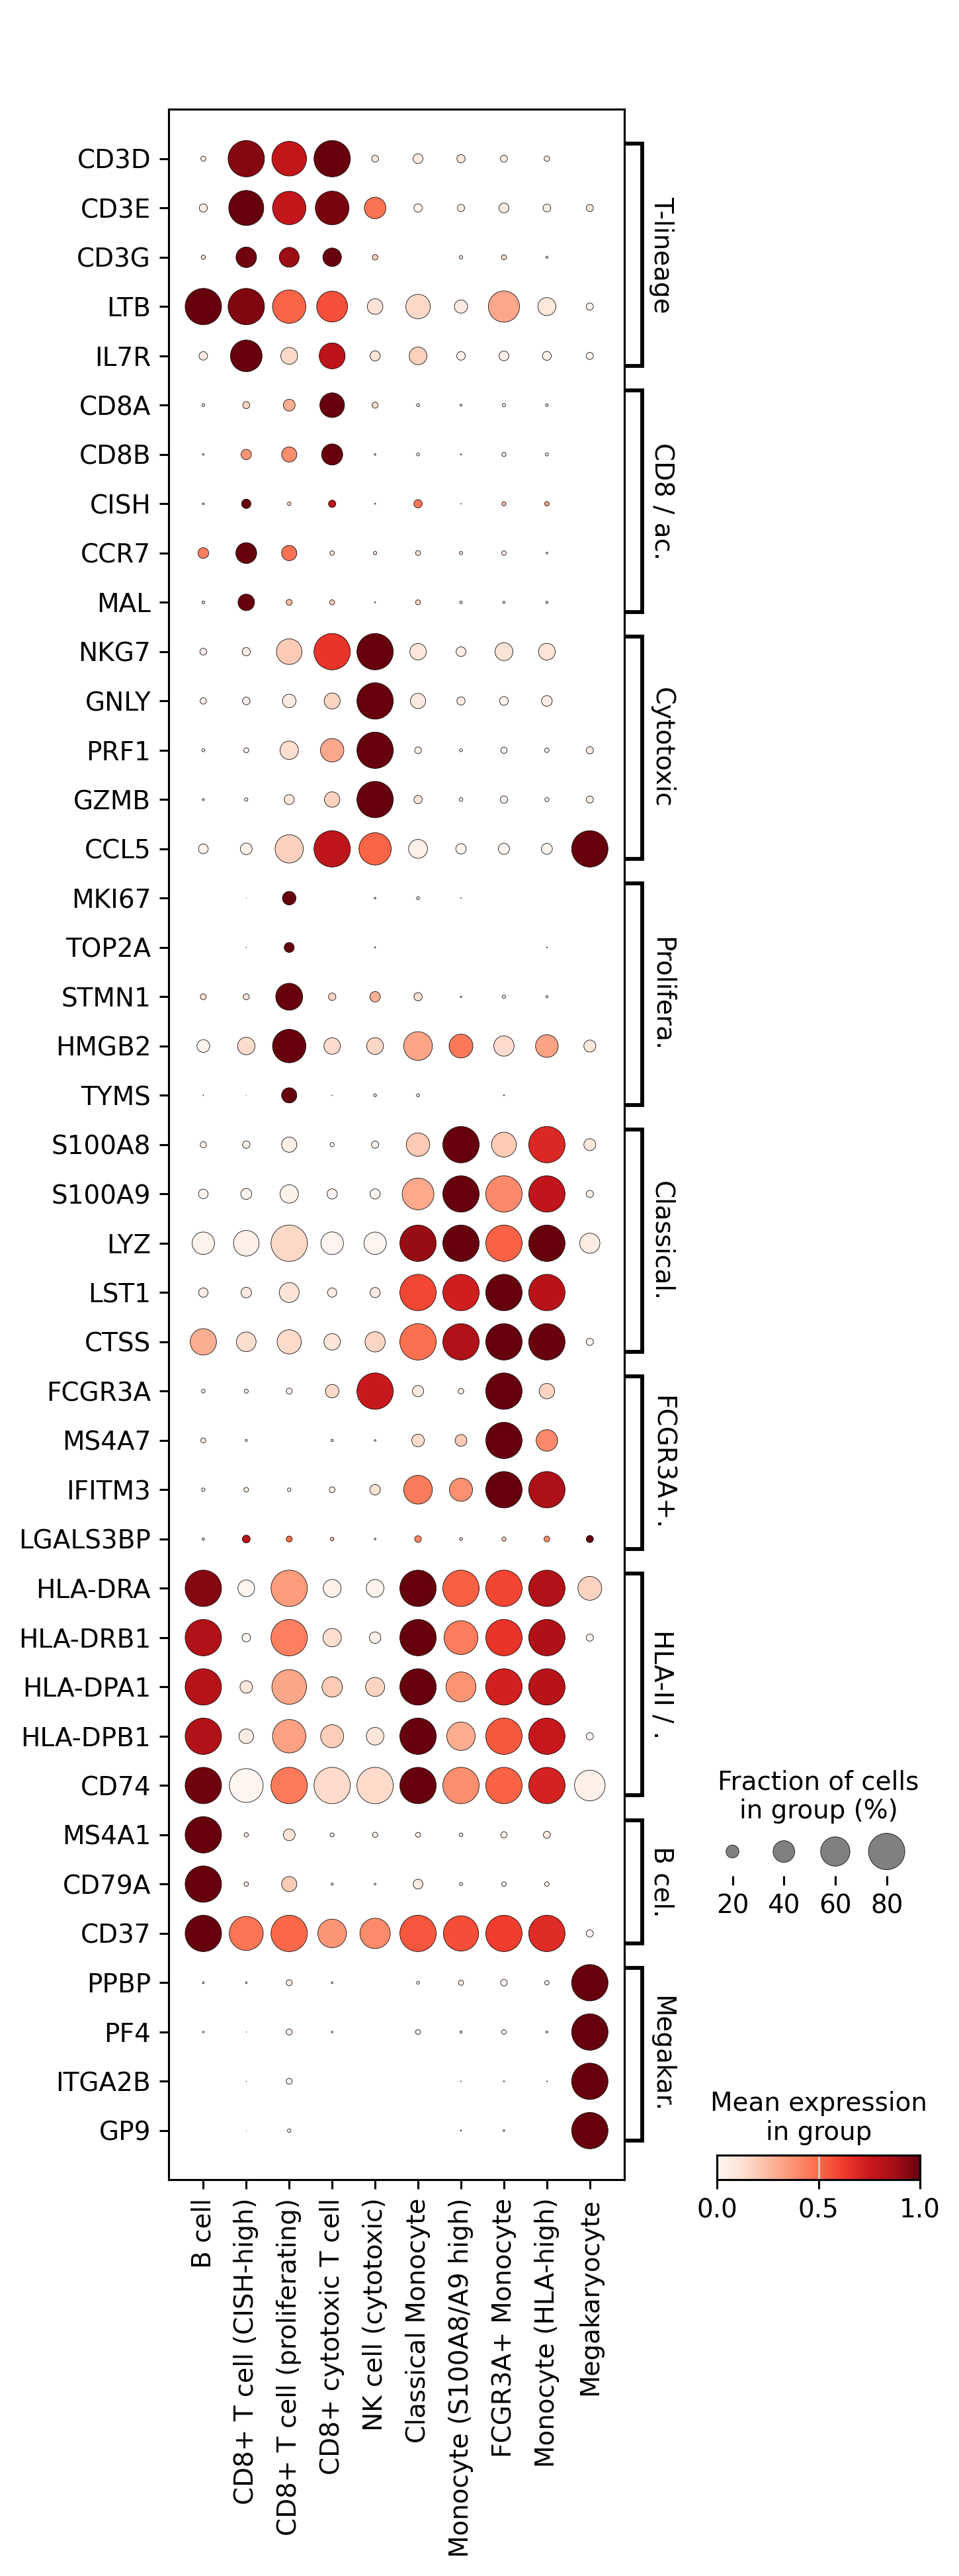

In [ ]:
MARKERS_FINE = {
    "T-lineage":         ["TRAC", "CD3D", "CD3E", "CD3G", "LTB", "IL7R"],
    "CD8 / activation":  ["CD8A", "CD8B", "CISH", "CCR7", "MAL"],
    "Cytotoxic":         ["NKG7", "GNLY", "PRF1", "GZMB", "CCL5"],
    "Proliferation":     ["MKI67", "TOP2A", "STMN1", "HMGB2", "TYMS"],
    "Classical mono":    ["S100A8", "S100A9", "LYZ", "LST1", "CTSS"],
    "FCGR3A+ mono":      ["FCGR3A", "MS4A7", "IFITM3", "LGALS3BP"],
    "HLA-II / APC":      ["HLA-DRA", "HLA-DRB1", "HLA-DPA1", "HLA-DPB1", "CD74"],
    "B cell":            ["MS4A1", "CD79A", "CD74", "CD37"],
    "Megakaryocyte":     ["PPBP", "PF4", "ITGA2B", "GP9"],
}


# ---------- Plot settings ----------
markers = filter_and_dedupe_markers(MARKERS_FINE, adata.var_names)
sc.pl.dotplot(
    adata,
    markers,
    groupby="fine_type",
    standard_scale="var",
    use_raw=False,
    swap_axes=True,
    dot_min=0.0,
    dot_max=0.8,
    show=True,
)


## (Optinal) Annotate existing clusters (v0.1.1+)

If you already have clusters (e.g., Seurat seurat_clusters, Leiden, etc.) and want to annotate each cluster once, then export a shareable table (CSV) and propagate labels to cells, use the utilities added in v0.1.1+.


In [ ]:
# CONFIG
cluster_col = "leiden"
out_csv = "cluster_curated_map.csv"
prefix = "Curated"

In [ ]:
# Curator Initialize
curator = LLMscCurator(api_key=GEMINI_API_KEY, model_name=MODEL_NAME)
curator.set_global_context(adata)

clusters = sorted(adata.obs[cluster_col].astype(str).unique())
cluster_results = {}
genes_by_cluster = {}

for cl in clusters:
    genes = curator.curate_features(
        adata,
        group_col=cluster_col,
        target_group=str(cl),
    )

    genes_by_cluster[str(cl)] = genes or []

    if genes:
        cluster_results[str(cl)] = curator.annotate(genes)
    else:
        cluster_results[str(cl)] = {
            "cell_type": "NoGenes",
            "confidence": "Low",
            "reasoning": "Curated gene list empty",
        }

In [ ]:
# EXPORT TABLE
df_cluster = export_cluster_annotation_table(
    adata,
    cluster_col=cluster_col,
    cluster_results=cluster_results,
    genes_by_cluster=genes_by_cluster,
    prefix=prefix,
)
df_cluster.to_csv(out_csv, index=False)
print(f"Wrote {out_csv}")

df_cluster

Wrote cluster_curated_map.csv


,leiden,n_cells,Curated_CellType,Curated_Confidence,Curated_Reasoning,Curated_Genes
0,0,591,CD8+ T cell,High,"The presence of CD3D, CD3E, CD3G, CD8B, CD2, a...",CD3D;CD3E;LTB;SELL;SRSF5;MAL;GIMAP5;HINT1;TRAF...
1,1,529,CD4+ T cell,High,The gene list contains canonical T cell marker...,LTB;IL32;CD3D;CD3E;CD2;GIMAP7;AQP3;HINT1;ARL6I...
2,2,505,Monocyte,High,The gene list is enriched for canonical monocy...,LYZ;S100A9;S100A8;TYROBP;CST3;FCN1;S100A6;LGAL...
3,3,366,CD8+ cytotoxic T cell,High,The gene list includes key markers for CD8+ T ...,CCL5;NKG7;IL32;GZMA;CTSW;CST7;GZMK;CD3D;PTPRCA...
4,4,348,B cell,High,The gene list contains canonical B cell marker...,CD74;HLA-DRA;CD79A;CD79B;HLA-DPB1;MS4A1;HLA-DQ...
5,5,151,NK cell (cytotoxic),High,The gene list is highly enriched for NK cell m...,NKG7;GNLY;GZMB;PRF1;CTSW;CST7;GZMA;FGFBP2;CD24...
6,6,148,Monocyte,High,The gene list is enriched for monocyte markers...,LST1;FCER1G;FCGR3A;AIF1;COTL1;SAT1;IFITM3;CTSS...
7,7,50,Myeloid Dendritic Cell,High,"Expression of HLA-DRB1, CD74, HLA-DPB1, HLA-DQ...",HLA-DRB1;CD74;HLA-DPB1;HLA-DQA1;HLA-DMA;HLA-DR...
8,8,12,Megakaryocyte-Erythroid Progenitor,High,The gene list contains key megakaryocyte marke...,SDPR;GNG11;PF4;PPBP;SPARC;RGS18;TPM4;NRGN;CD9;...


In [ ]:
# PER-CELL LABEL
apply_cluster_map_to_cells(
    adata,
    cluster_col=cluster_col,
    df_cluster=df_cluster,
    label_col=f"{prefix}_CellType",
    new_col=f"{prefix}_CellType",
)

AnnData object with n_obs × n_vars = 2700 × 13714
    obs: 'n_genes', 'leiden', 'Curated_CellType'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

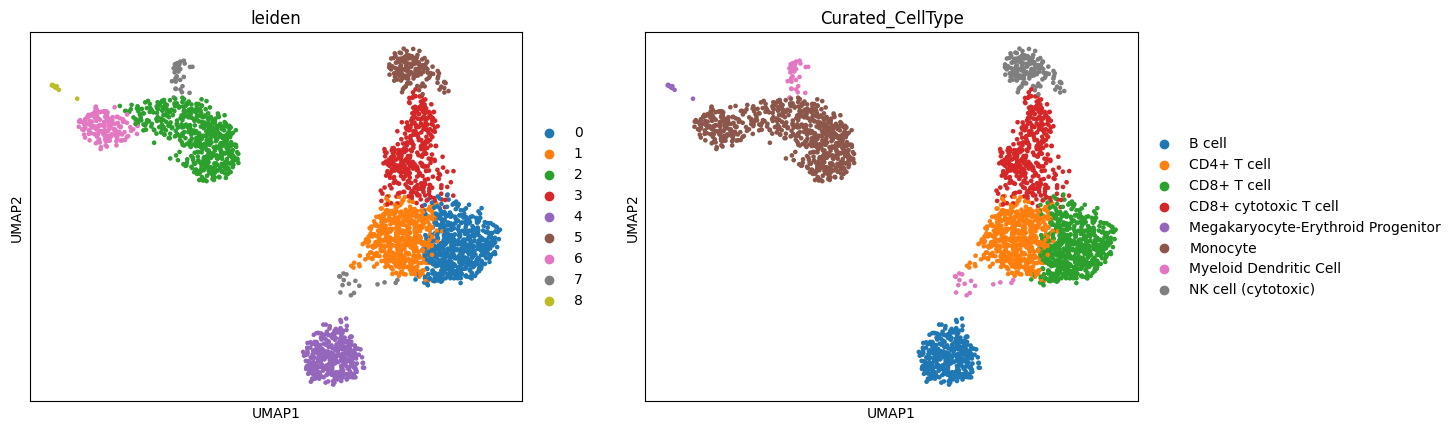

In [ ]:
sc.pl.umap(adata, color=["leiden", f"{prefix}_CellType"])


In [ ]:
# ---- OPTIONAL: LABEL HARMONIZATION ----
label_map = {
    # Example: Add according to your project
}

if label_map:
    adata = harmonize_labels(
        adata,
        col=f"{prefix}_CellType",
        mapping=label_map,
        new_col=f"{prefix}_CellType_harmonized",
        keep_raw=True,
    )
    out_csv2 = out_csv.replace(".csv", "_harmonized.csv")
    df_cluster2 = df_cluster.copy()
    df_cluster2[f"{prefix}_CellType"] = df_cluster2[f"{prefix}_CellType"].replace(label_map)
    df_cluster2.to_csv(out_csv2, index=False)
    print(f"Wrote {out_csv2}")

# ---- QUICK CHECK ----
print(df_cluster[[cluster_col, "n_cells", f"{prefix}_CellType", f"{prefix}_Confidence"]].head())